In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima.arima as pm
from sklearn.metrics import mean_absolute_error
from pandas.tseries.offsets import DateOffset

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('csv/perrin-freres-monthly-champagne-.csv')
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [3]:
# changing names of the columns
df.columns = ['Month','Sales']

In [4]:
df.drop([105,106], axis=0, inplace=True) # last 2 rows are not usable

In [5]:
df

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0


In [6]:
df.info() # have to convert object to Datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [7]:
df['Month'] = pd.to_datetime(df['Month'])

df = df.set_index('Month')

In [8]:
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


# Stationarity check

<AxesSubplot:xlabel='Month'>

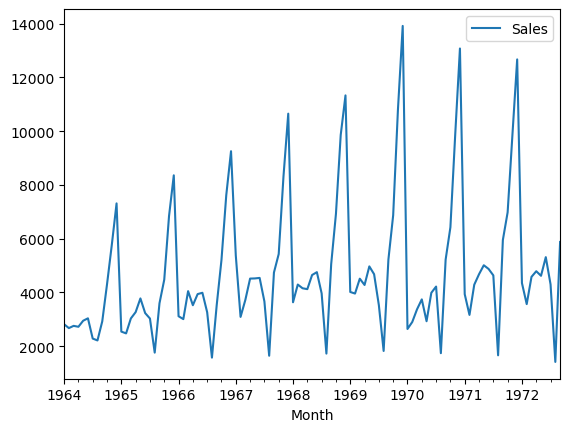

In [9]:
df.plot()

# Graphically data not stationary

## 'Seasonality' present in graph.

### Stationarity checking numerically - ADFuller Test

In [10]:
# null hypothesis - data is not stationary

result = adfuller(df.values, autolag='AIC')
result[1]

0.3639157716602465

### Therefore, accepting Null hypothesis - data is not stationary. 

# ROLLING STATS


#### mean and std deviation, between any 2 intervals, should be constant (almost constant is also okay)

In [11]:
rolling_mean = df.rolling(12).mean()
rolling_std = df.rolling(12).std()

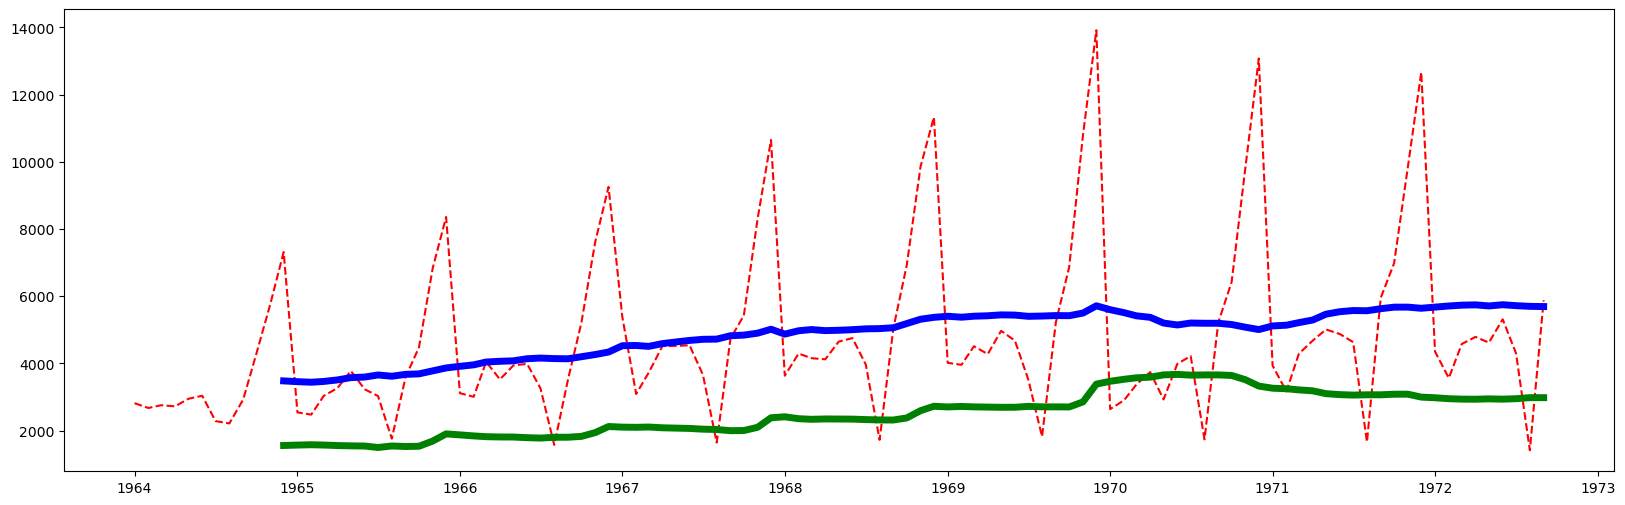

In [12]:
plt.figure(figsize=(20,6))
plt.plot(df, linestyle='--', color='red')
plt.plot(rolling_mean, color='blue', linewidth=5)
plt.plot(rolling_std, color='green', linewidth=5)

## By the method of rolling statistics, mean and standard deviation, both have an upward trend component. Therefore, not stationary. 

In [13]:
decompose = seasonal_decompose(df['Sales'], model = 'multiplicative', period=12)

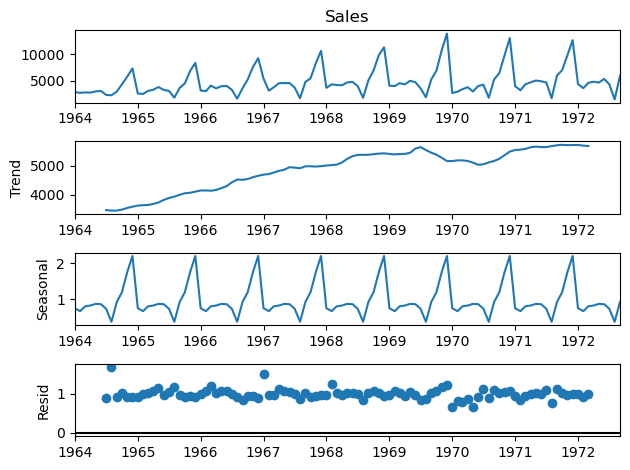

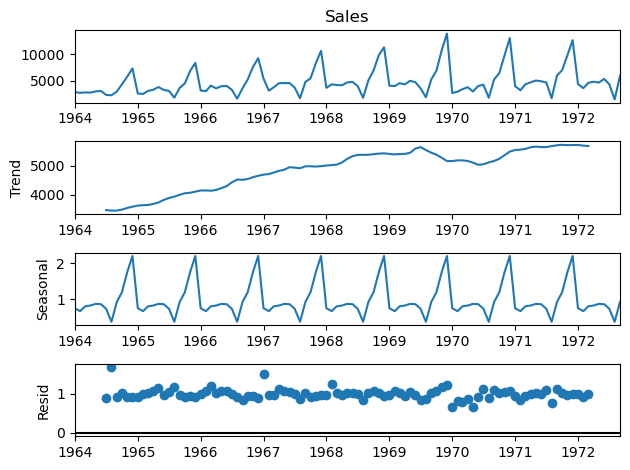

In [14]:
decompose.plot()

# Making time series stationary

### Ways to make it _Stationary_ : 

1. DIFFERENCING
2. TRANSFORMATION
3. DIFFERENCING + TRANSFORMATION
4. ROLLING STATS (by changing window-size)

### Differencing

In [15]:
df['Difference'] = df['Sales'] - df['Sales'].shift(12) #considering seasonality of 12 months

In [16]:
df

,Sales,Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
...,...,...
1972-05-01,4618.0,-392.0
1972-06-01,5312.0,438.0
1972-07-01,4298.0,-335.0


<AxesSubplot:xlabel='Month'>

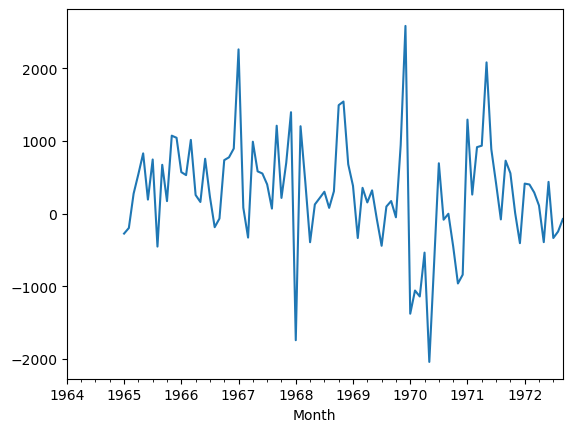

In [18]:
df['Difference'].plot() # seasonality and trend component are gone

In [20]:
# stationary check using ADFuller Test

# null hypothesis - data is not stationary
#alternate hypothesis - data is stationary
new_result = adfuller(df['Difference'].dropna(), autolag='AIC')
new_result[1]

2.060579696813685e-11

### p-value is less than 0.05
### Therefore, rejecting null hypothesis and accepting _Alternate Hypothesis_

In [22]:
rolling_mean = df['Difference'].rolling(12).mean()
rolling_std = df['Difference'].rolling(12).std()

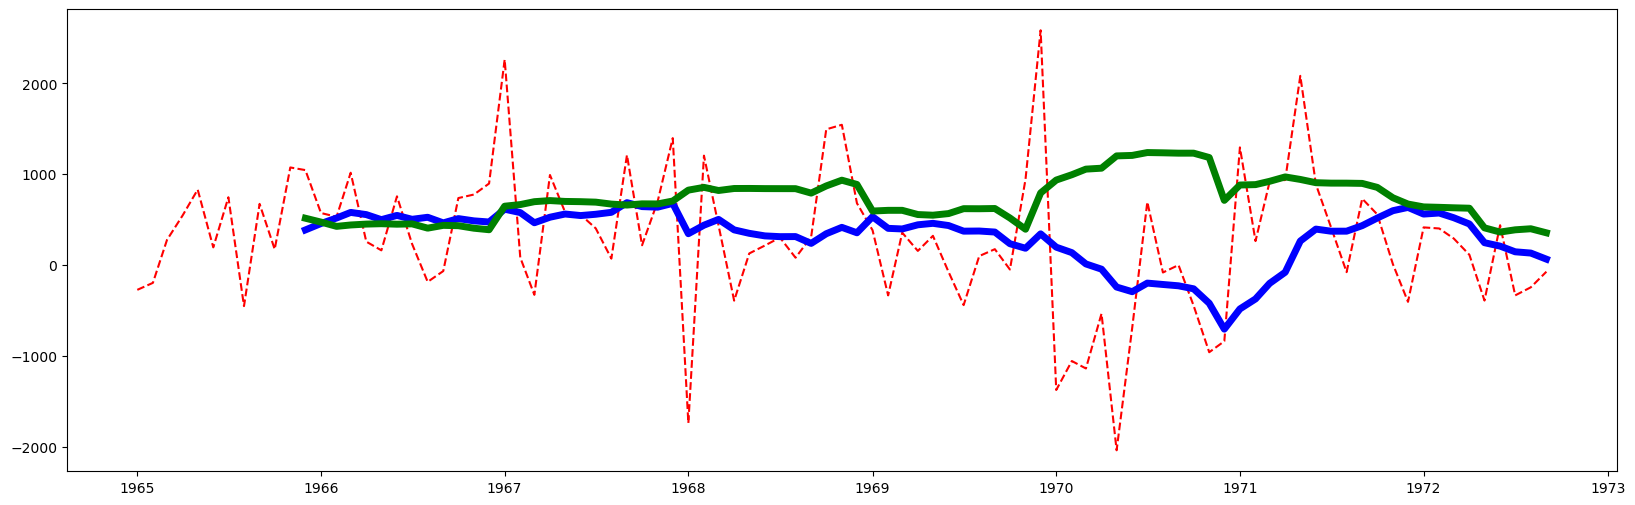

In [23]:
plt.figure(figsize=(20,6))
plt.plot(df['Difference'], linestyle='--', color='red')
plt.plot(rolling_mean, color='blue', linewidth=5)
plt.plot(rolling_std, color='green', linewidth=5)

# MODEL BUILDING

#### __AIM : To find p,d,q values for ARIMA model__ or how many lags do we need to consider

### ACF (MA)- Includes all data including noise
### PACF (AR) - Includes partial data which directly affect the prediction

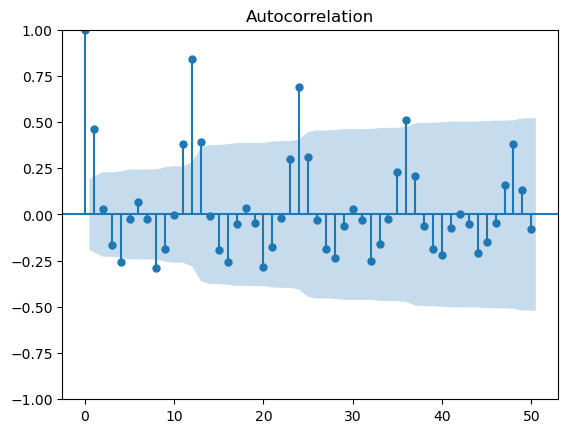

<Figure size 2000x600 with 0 Axes>

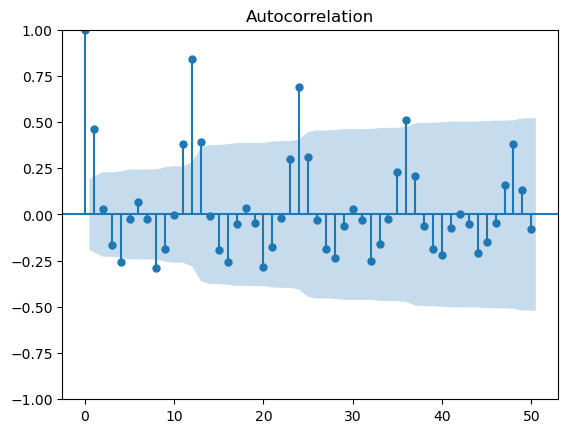

In [24]:
plt.figure(figsize=(20,6))
sm.graphics.tsa.plot_acf(df['Sales'], lags=50)

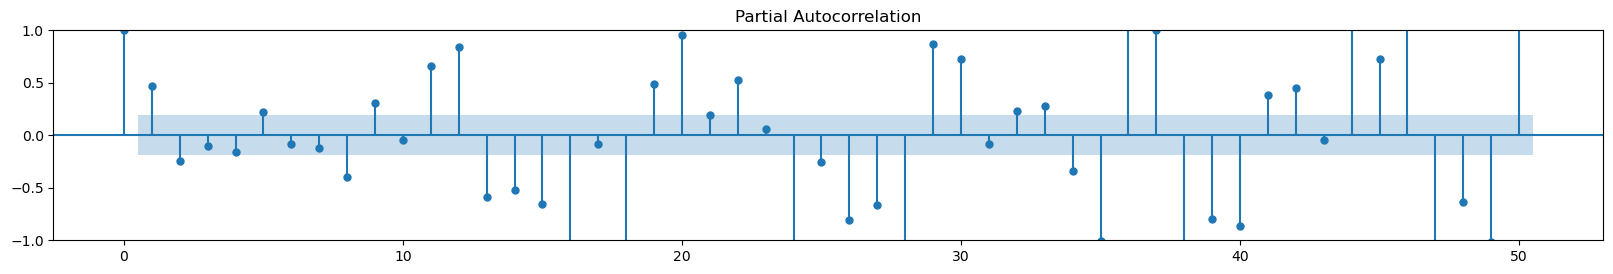

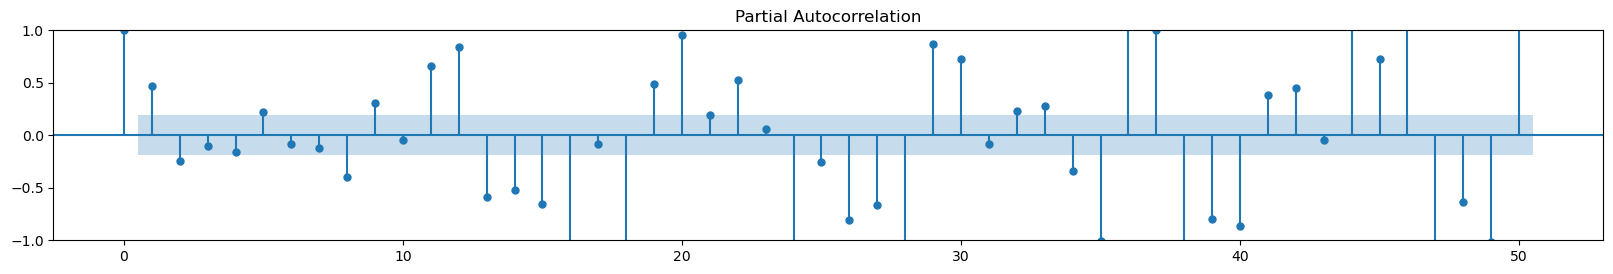

In [25]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_pacf(df['Sales'], lags=50, ax=ax1)

## From graph, considering p,q = (1,1,1)

### d=1 because 1st order differencing

In [27]:
# AIC method to consider p,q,d
lst = []
for i in range(3):
    for j in range(3):
        for z in range(3):
            model = ARIMA(df['Difference'], order=(i,z,j))
            model_fit = model.fit()
            lst.append(model_fit.aic)
            print("ARIMA({},{},{}) - AIC:{}".format(i,z,j,model_fit.aic))

ARIMA(0,0,0) - AIC:1500.8862454704806
ARIMA(0,1,0) - AIC:1542.8604678589022
ARIMA(0,2,0) - AIC:1645.5672761573678
ARIMA(0,0,1) - AIC:1498.9135363018192
ARIMA(0,1,1) - AIC:1504.857780660484
ARIMA(0,2,1) - AIC:1550.2593668599038
ARIMA(0,0,2) - AIC:1500.6204107927217
ARIMA(0,1,2) - AIC:1503.6685174849497
ARIMA(0,2,2) - AIC:1516.3927237937569
ARIMA(1,0,0) - AIC:1498.4464759130647
ARIMA(1,1,0) - AIC:1526.291788613898
ARIMA(1,2,0) - AIC:1602.42101529607
ARIMA(1,0,1) - AIC:1500.0049577446969
ARIMA(1,1,1) - AIC:1503.5913174211555
ARIMA(1,2,1) - AIC:1534.5403913830353
ARIMA(1,0,2) - AIC:1502.0974789441882
ARIMA(1,1,2) - AIC:1504.9019818346114
ARIMA(1,2,2) - AIC:1515.8050715830936
ARIMA(2,0,0) - AIC:1500.250162776322
ARIMA(2,1,0) - AIC:1517.2830114490007
ARIMA(2,2,0) - AIC:1574.8030158869417
ARIMA(2,0,1) - AIC:1502.011398409475
ARIMA(2,1,1) - AIC:1505.2869442373058
ARIMA(2,2,1) - AIC:1526.1662124727163
ARIMA(2,0,2) - AIC:1501.2924817580829
ARIMA(2,1,2) - AIC:1505.025016393276
ARIMA(2,2,2) - AIC:

In [28]:
min(lst)
# ARIMA(1,0,0) - AIC:1498.4464759130647

1498.4464759130647

## From AIC method, we can see p,q,d = (1,0,0)

# ARIMA

In [29]:
df

,Sales,Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
...,...,...
1972-05-01,4618.0,-392.0
1972-06-01,5312.0,438.0
1972-07-01,4298.0,-335.0


In [30]:
tuned = ARIMA(df['Sales'], order=(1,1,1))
model = tuned.fit()

In [31]:
actual = df['Sales'][12:20]
predict = model.predict(0,7)
mean_absolute_error(actual,predict)

947.4619501306981

<AxesSubplot:xlabel='Month'>

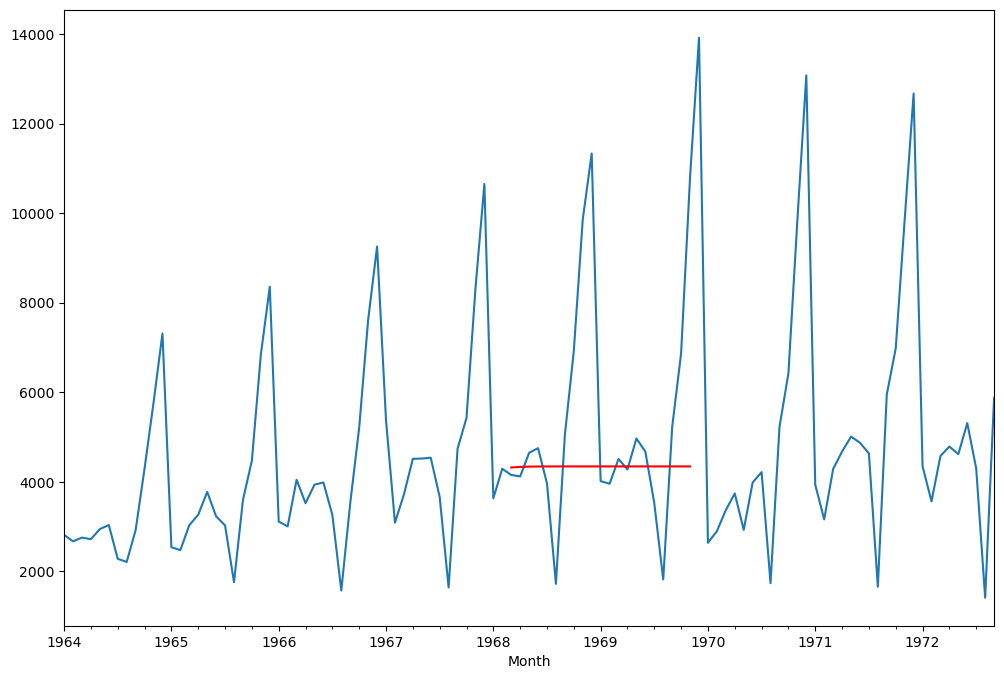

In [32]:
df['ARIMA Prediction']=model.predict(start=50,end=70,dynamic=True)
df['Sales'].plot(figsize=(12,8))
df['ARIMA Prediction'].plot(figsize=(12,8),color='red')

In [57]:
tuned = ARIMA(df['Sales'], order=(1,0,0))
model = tuned.fit()

actual = df['Sales'][12:20]
predict = model.predict(0,7)
mean_absolute_error(actual,predict)

1059.3914127661042

## MAE is higher with both values of p,d,q (chosen by graph and AIC)
## Prediction is also not good.

## Conclusion - Do not use ARIMA with seasonal data.

#  SARIMA - Seasonal ARIMA

In [34]:
# p,d,q,m -> m = The number of time steps for a single seasonal period
# m - in a season how many times you have done shifting
tuned = SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima = tuned.fit()

In [35]:
actual = df['Sales'][12:20]
predict = sarima.predict(0,7)
mean_absolute_error(actual,predict)

713.1373212315391

<AxesSubplot:xlabel='Month'>

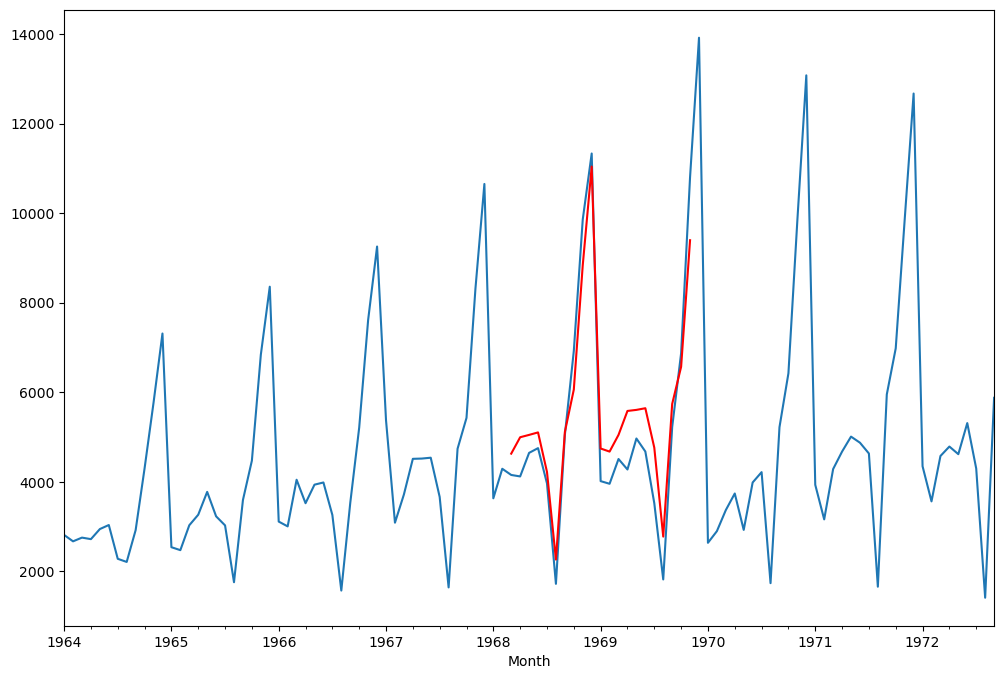

In [46]:
df['SARIMA Prediction']=sarima.predict(start=50,end=70,dynamic=True)
df['Sales'].plot(figsize=(12,8))
df['ARIMA Prediction'].plot(figsize=(12,8),color='red')

# MAE is less and Predictions on graph fit almost well in SARIMA.

# Auto-ARIMA

#### automatic selection of p,q,d

In [39]:
model = pm.auto_arima(df['Sales'], start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=True,   
                      suppress_warnings=True)

In [40]:
model # order chosen by auto-arima is (0,0,1)

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

#  Predicting future forecast

In [48]:
df.index[-1]

Timestamp('1972-09-01 00:00:00')

In [49]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [50]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [51]:
future_datest_df

,Sales,Difference,ARIMA Prediction,SARIMA Prediction
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN,NaN


In [52]:
future_df=pd.concat([df,future_datest_df])

In [53]:
future_df

,Sales,Difference,ARIMA Prediction,SARIMA Prediction
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,NaN,NaN,NaN
1964-03-01,2755.0,NaN,NaN,NaN
1964-04-01,2721.0,NaN,NaN,NaN
1964-05-01,2946.0,NaN,NaN,NaN
...,...,...,...,...
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN


<AxesSubplot:>

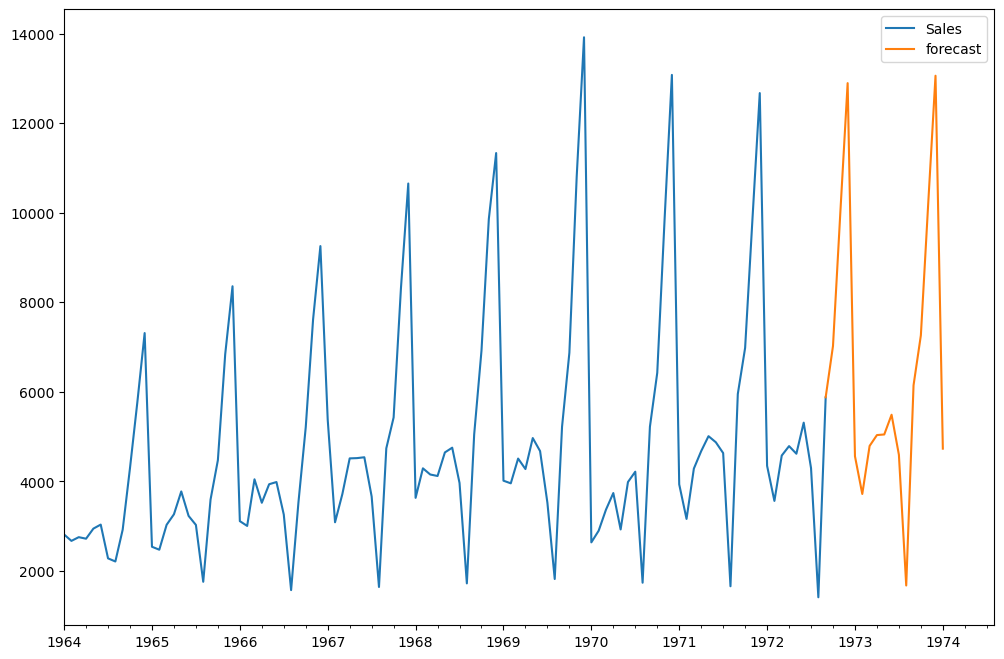

In [55]:
future_df['forecast'] = sarima.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 